In [1]:
%matplotlib inline

AlazarTech recently introduced support for trigger holdoff in the firmware of the 9360. In this report we investigate the difference enabling and disabling this.

For this report we will use a Alazar 9360 and a Keysight/Agilent 33522B Waveform generator. The output 
of the waveform generator channel 1 is supplied to the Alazar channel A and the Sync output of the Wavefrom generator is ued to trigger the Alazar using the external trigger interface. In addition we are using an Alazar controller from qdev_wrappers
https://github.com/qdev-dk/qdev-wrappers/

In [2]:
import qcodes as qc
from qdev_wrappers.alazar_controllers.ATSChannelController import ATSChannelController
from qdev_wrappers.alazar_controllers.alazar_channel import AlazarChannel
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
from qcodes.instrument_drivers.Keysight.KeysightAgilent_33XXX import WaveformGenerator_33XXX
from qcodes.dataset.database import initialise_database

from qcodes.dataset.experiment_container import new_experiment
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id

In [3]:
alazar = AlazarTech_ATS9360('Alazar')
myctrl = ATSChannelController(name='my_controller', alazar_name='Alazar')
wfg = WaveformGenerator_33XXX('wfg', 'TCPIP0::192.168.15.108::inst0::INSTR')
chan = AlazarChannel(myctrl, 'myrecvssamples', demod=False, average_records=False, integrate_samples=False)

Connected to: Agilent Technologies 33522B (serial:MY57800256, firmware:3.05-1.19-2.00-52-00) in 0.14s


For this to work the firmware of the Alazar must be upgraded to at least version 21.07 

In [4]:
alazar.get_idn()

{'firmware': '21.07',
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970396',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.1.2',
 'SDK_version': '6.1.2',
 'latest_cal_date': '25-01-17',
 'memory_size': '4294967294',
 'asopc_type': '1729463136',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

In [5]:
wfg.get_idn()

{'vendor': 'Agilent Technologies',
 'model': '33522B',
 'serial': 'MY57800256',
 'firmware': '3.05-1.19-2.00-52-00'}

In this example we are using a 20 MHz sin at 100 mVPP and a matching sync signal at each period of the sin.

In [6]:
wfg.ch1.frequency(20e6)
wfg.ch1.offset(0)
wfg.ch1.amplitude_unit('VPP')
wfg.ch1.amplitude(0.1)
wfg.ch1.function_type('SIN')
wfg.sync.source(1)

wfg.sync.output('ON')
wfg.ch1.output('ON')

# Configure all settings in the Alazar card
with alazar.syncing():    
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(1_000_000_000)
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(.4)
    alazar.channel_range2(.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_operation('TRIG_ENGINE_OP_J')
    alazar.trigger_engine1('TRIG_ENGINE_J')
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_slope1('TRIG_SLOPE_POSITIVE')
    alazar.trigger_level1(160)
    alazar.trigger_engine2('TRIG_ENGINE_K')
    alazar.trigger_source2('DISABLE')
    alazar.trigger_slope2('TRIG_SLOPE_POSITIVE')
    alazar.trigger_level2(128)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_2V5')
    alazar.trigger_delay(0)
    alazar.timeout_ticks(0)
    alazar.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    alazar.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on
    

And a record length of 2.2e-6 corrosponding to 455 KHz and expect ~44 triggers per record.

In [7]:
myctrl.int_time(2.2e-6)

chan.num_averages(1)
chan.records_per_buffer(10)
chan.alazar_channel('A')
chan.prepare_channel()

In [8]:
initialise_database()
new_experiment(name='alazar_holdoff', sample_name="no sample")

alazar_holdoff#no sample#2@C:\Users\Jens/experiments.db
-------------------------------------------------------

Starting experimental run with id: 8


([<matplotlib.axes._subplots.AxesSubplot at 0x15ffdfd5f28>],
 [<matplotlib.colorbar.Colorbar at 0x15ffdfeee80>])

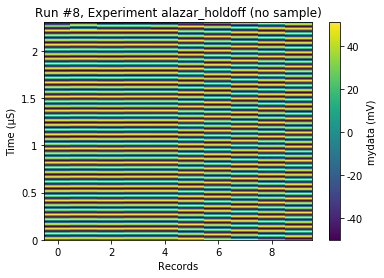

In [9]:
# And then run an experiment
alazar.trigger_holdoff(False)
meas = Measurement()
meas.register_parameter(chan.data)  # register the first independent parameter
with meas.run() as datasaver:
    datasaver.add_result((chan.data, chan.data()))
    
    dataid = datasaver.run_id  # convenient to have for plotting

plot_by_id(dataid)

This signal is clearly distorted both due to apparent drift of the trigger to signal and apparent shifts towards the end of the record. The distortion seems to depend on the exact relation between the record length and trigger rate and are not observed for all record_length > 1/trigger_rate 

Starting experimental run with id: 9


([<matplotlib.axes._subplots.AxesSubplot at 0x15ffec53748>],
 [<matplotlib.colorbar.Colorbar at 0x15fff316f98>])

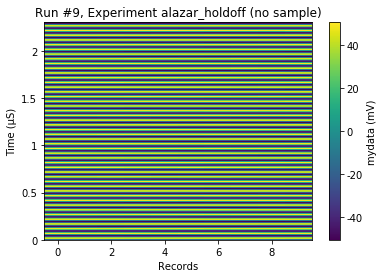

In [10]:
# And then run an experiment
alazar.trigger_holdoff(True)
meas = Measurement()
meas.register_parameter(chan.data)  # register the first independent parameter
with meas.run() as datasaver:
    datasaver.add_result((chan.data, chan.data()))
    
    dataid = datasaver.run_id  # convenient to have for plotting

plot_by_id(dataid)

If we enable trigger holdoff the distortion is gone. If you use a external trigger it's very important to ensure that you either enable trigger holdoff or ensure that record_length > 1/trigger_rate